# Mały projekt 1: wizualizacja poziomu zanieczyszczeń (PM2.5)

Główny Inspektorat Ochrony Środowiska (GIOS) udostępnia dane o jakości powietrza w Polsce na stronie [https://powietrze.gios.gov.pl](https://powietrze.gios.gov.pl), tj. poziom stężenia pyłów PM2.5, PM10, SO2 i innych zanieczyszczeń. Dane te są szczególnie przydatne w analizach środowiskowych i zdrowotnych. W tym zadaniu interesują nas godzinne pomiary stężeń drobnego pyłu **PM2.5** (pyłu o średnicy poniżej 2.5 µm) w latach **2014, 2019 i 2024**. Pyły PM2.5 są one bardzo szkodliwe dla zdrowia, gdyż mogąc przenikać głęboko do układu oddechowego i krwiobiegu. Zadanie polega na przeprowadzeniu analizy danych wraz z opisami czynności oraz wykresami.

## Wymagania ogólne

- Rozwiązanie należy przygotować w formie **Jupyter Notebooka (`.ipynb`)**.  Rozwiązanie proszę przesłać przez Moodle’a.
- Wszystkie operacje czyszczenia i łączenia danych wykonaj **programistycznie**, bez ręcznej edycji plików.
- Do każdego punktu należy obowiązkowo dodać opis z analizą otrzymanych wyników.  
- Zadanie należy wykonać w wylosowanych parach. Obie osoby z pary przesyłają **identyczne pliki** i dodają na początku notebooka opis swojego wkładu.
- Ocena jest wspólna dla pary, a nie indywidualna.

## Dane wejściowe i metadane

- Każdy rok to archiwum ZIP dostępne pod adresem [https://powietrze.gios.gov.pl/pjp/archives/](https://powietrze.gios.gov.pl/pjp/archives/).
- Wewnątrz znajdują się pliki Excel, np. `2024_PM25_1g.xlsx`.
- Poniższa funkcja `download_gios_archive` pozwala odczytać odpowiedni zbior danych; resztę danych pomijamy.
- Użyj pliku metadanych (dostępnego na tej samej stronie), aby zaktualizować **kody stacji** (część stacji mogła w międzyczasie zmienić nazwę). W metadanych znajdziesz odpowiednie kolumny.

## Zadania

### 1. Wczytanie i czyszczenie danych

Wczytaj dane dla lat **2014, 2019 i 2024**, oczyścić je z niepotrzebnych wierszy oraz ujednolić ich format. Zaktualizuj stare kody stacji zgodnie z metadanymi. Pozostaw tylko stacje występujące we wszystkich trzech latach. Informacje o stacjach pomiarowych warto uzupełnić o miejscowości dostępne w metadanych, np. za pomocą MultiIndex: (miejscowość, kod stacji). Pomiary dokonane o północy (00:00:00) powinny być potraktowane jako dotyczące poprzedniego dnia. Połącz dane z trzech lat w jeden `DataFrame` i zapisz do pliku.

### 2. Średnie miesięczne + trend dla miast

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

## Dodatkowe wymagania i sugestie

- Notebook powinien zawierać *sanity checks*, np.:
  - liczba stacji w każdym pliku,
  - liczba dni w każdym roku,  
  - kilka przykładowych mapowań kodów stacji,  
- Wszystkie wykresy powinny mieć tytuły, legendy i krótki opis interpretacji.
- Zachęcamy do weryfikacji kodu napisanego przez drugą osobę, gdyż ocena jest wspólna.
- Można wykorzystać dowolne poznane biblioteki do analizy i wizualizacji danych w Pythonie.

## Kryteria oceny

- Zadanie 1: 3 pkt
- Zadanie 2: 2 pkt
- Zadanie 3: 1.5 pkt
- Zadanie 4: 2 pkt
- Jakość wyjaśnień, interpretacje, opis wkładu: 1.5 pkt



# Opis wkładu w wykonanie projektu
- Zadanie 1, 3: Karolina Winczewska
- Zadanie 2, 4: Wojtek Laskowski

In [9]:
import pandas as pd
import requests
import zipfile
import io
import os
import seaborn as sns

# id archiwum dla poszczególnych lat i metadanych
gios_archive_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
gios_url_ids = {2014: "302", 2019: "322", 2024: "582", "meta": "584"}
gios_pm25_file = {
    2014: "2014_PM2.5_1g.xlsx",
    2019: "2019_PM25_1g.xlsx",
    2024: "2024_PM25_1g.xlsx",
}

# funkcja do ściągania podanego archiwum


def download_gios_archive(year, gios_id, filename):
    # Pobranie archiwum ZIP do pamięci
    url = f"{gios_archive_url}{gios_id}"
    response = requests.get(url)
    response.raise_for_status()  # jeśli błąd HTTP, zatrzymaj

    # Otwórz zip w pamięci
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # znajdź właściwy plik z PM2.5
        if not filename:
            print(f"Błąd: nie znaleziono {filename}.")
        else:
            # wczytaj plik do pandas
            with z.open(filename) as f:
                try:
                    df = pd.read_excel(f, header=None)
                except Exception as e:
                    print(f"Błąd przy wczytywaniu {year}: {e}")
    return df


# funkcja do ściągania metadanych
def download_gios_meta(gios_id):
    # Pobranie metadanych do pamięci
    url = f"{gios_archive_url}{gios_id}"
    response = requests.get(url)
    response.raise_for_status()  # jeśli błąd HTTP, zatrzymaj

    # wczytaj plik do pandas
    df = pd.read_excel(io.BytesIO(response.content))
    return df

In [10]:
# Wczytanie danych dla lat 2014, 2019, 2024 oraz metadanych

df2014 = download_gios_archive(2014, gios_url_ids[2014], gios_pm25_file[2014])
df2019 = download_gios_archive(2029, gios_url_ids[2019], gios_pm25_file[2019])
df2024 = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])

meta = download_gios_meta(gios_url_ids["meta"])

/usr/lib/python3/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


# Zadanie 1

In [ ]:
# Funkcje czyszczące pliki:
# - ujednolicają nagłówki
# - usuwają niepotrzebne wiersze
# - zachowują odpowiednie indeksowanie


def clean_2014(df):
    df.columns = df.iloc[0]
    df = df.drop([0, 1, 2])
    df = df.reset_index(drop=True)
    return df


def clean_2019(df):
    df.columns = df.iloc[1]
    df = df.drop([0, 1, 2, 3, 4, 5])
    df = df.reset_index(drop=True)
    return df


def clean_2024(df):
    df.columns = df.iloc[1]
    df = df.drop([0, 1, 2, 3, 4, 5])
    df = df.reset_index(drop=True)
    return df


# Funkcja zmieniająca datę pomiarów wykonanych o północy na poprzedni dzień:
def midnight(df):
    date = df.columns[0]

    # Zapewnienie odpowiedniego formatu kolumnie z datą
    df[date] = pd.to_datetime(df[date])

    # Zidentyfikowanie pomiarów wykonanych o północy i cofnięcie o jeden dzień
    mid = df.iloc[:, 0].dt.hour == 0
    new_date = df[date] - pd.Timedelta(days=1)
    df.loc[mid, date] = new_date
    return df


# funkcja znajdująca stacje występujące we wszystkich 3 latach
def common_stations(df2014, df2019, df2024, meta):

    # utworzenie zbiorów stacji z poszczególnych lat
    stations2014 = set(df2014.columns[1:])
    stations2019 = set(df2019.columns[1:])
    stations2024 = set(df2024.columns[1:])

    # znalezienie wspólnych stacji
    common = stations2014 & stations2019 & stations2024

    df2014_common = df2014[[df2014.columns[0]] + list(common)]
    df2019_common = df2019[[df2019.columns[0]] + list(common)]
    df2024_common = df2024[[df2024.columns[0]] + list(common)]

    return df2014_common, df2019_common, df2024_common


# funkcja dodająca miejscowość do kodu stacji
def add_city(df, meta_city):

    # usunięcie duplikatów w metadanych
    meta_city = meta_city[~meta_city.index.duplicated()]

    station_code = df.columns[1:]

    # pobranie miejscowości dla każdej stacji i utworzenie listy krotek
    cities = meta_city.reindex(station_code).fillna("UNKNOWN")
    multi_cols = [("datetime", "")] + list(zip(cities, station_code))

    df.columns = pd.MultiIndex.from_tuples(
        multi_cols, names=["Miejscowość", "Kod stacji"]
    )
    return df

In [ ]:
# Wstępne ujednolicenie danych
df2014_clean = clean_2014(df2014)
df2019_clean = clean_2019(df2019)
df2024_clean = clean_2024(df2024)

# Zmiana daty pomiarów wykonanych o północy na poprzedni dzień
df2014_clean = midnight(df2014_clean)
df2019_clean = midnight(df2019_clean)
df2024_clean = midnight(df2024_clean)

# Aktualizacja kodów stacji
meta_code = meta[
    ["Stary Kod stacji \n(o ile inny od aktualnego)", "Kod stacji"]
]
mapping_code = dict(zip(meta_code.iloc[:, 0], meta_code.iloc[:, 1]))
df2014_clean.rename(columns=mapping_code, inplace=True)
df2019_clean.rename(columns=mapping_code, inplace=True)
df2024_clean.rename(columns=mapping_code, inplace=True)

# Pozostawienie tylko tych stacji, które występują we wszystkich 3 latach
df2014_common, df2019_common, df2024_common = common_stations(
    df2014_clean, df2019_clean, df2024_clean, meta
)

# Uzupełnienie kodu stacji o miejscowość 
city = meta.set_index("Kod stacji")["Miejscowość"]
df2014_common = add_city(df2014_common, city)
df2019_common = add_city(df2019_common, city)
df2024_common = add_city(df2024_common, city)

# Połączenie danych i zapisanie do pliku
df_pm25 = pd.concat([df2014_common, df2019_common, df2024_common], axis=0)
df_pm25.to_csv("PM25.csv", index=False)

In [5]:
# Sanity checks

print("Liczba stacji występujących we wszystkich 3 latach: ", len(df_pm25.columns[1:]))
print(
    "Liczba dni w kolejnych latach (2014, 2019, 2024): ",
    df_pm25["datetime"].dt.date.groupby(df_pm25["datetime"].dt.year).nunique(),
)
print(
    "Przykładowe kody stacji wraz z odpowiadającymi im miejscowościami: ",
    df_pm25.columns[:5],
)

Liczba stacji występujących we wszystkich 3 latach:  20
Liczba dni w kolejnych latach (2014, 2019, 2024):  datetime
2014    365
2019    365
2024    366
Name: datetime, dtype: int64
Przykładowe kody stacji wraz z odpowiadającymi im miejscowościami:  MultiIndex([('datetime',             ''),
            (  'Kraków', 'MpKrakBulwar'),
            (    'Łódź', 'LdLodzCzerni'),
            ('Warszawa', 'MzWarWokalna'),
            (  'Kraków', 'MpKrakAlKras')],
           names=['Miejscowość', 'Kod stacji'])


## Opis otrzymanych danych
W wyniku czyszczenia danych otrzymano 'DataFrame' składający się z 23 stacji występujących w każdym z 3 lat (2014, 2019, 2024) wraz z przypisanymi do nich miejsowościami oraz danymi pomiarowymi. Pomiary wykonane o północy zostały potraktowane jako dotyczące poprzedniego dnia. W otrzymanych danych występują dwie miejscowości (Waszrszawa i Kraków), które mają przypisaną więcej niż jedną stację pomiarową (dwie). Dane z roku 2024 zawierają więcej pomiarów, dlatego, że rok ten był rokiem przestępnym.

# Zadanie 2

/tmp/ipykernel_29090/1344954723.py:18: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(["Miejscowość", "Kod stacji"])


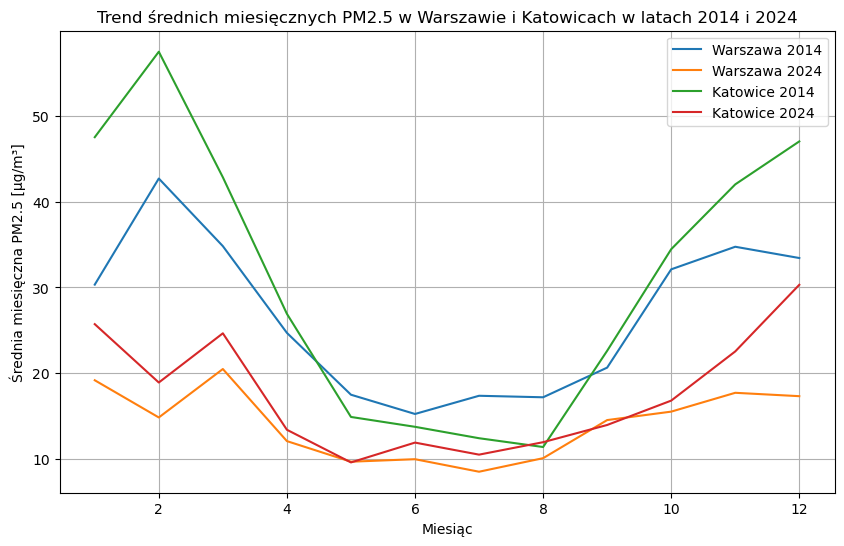

In [15]:
import matplotlib.pyplot as plt


# Funkcja oblicza średnie dla poszczególnych stacji dla każdego miesiąca każdego roku
def calc_monthly_means(df_pm25):
    df_pm25[("datetime", "")] = pd.to_datetime(df_pm25[("datetime", "")])

    # Dodanie kolumn "Rok" i "Miesiąc"
    df_pm25[("Rok", "")] = df_pm25[("datetime", "")].dt.year
    df_pm25[("Miesiąc", "")] = df_pm25[("datetime", "")].dt.month
    df_pm25[("Dzień", "")] = df_pm25[("datetime", "")].dt.day

    # formatowanie ramki danych
    df_pm25_formated = (
        df_pm25.set_index(
            [("datetime", ""), ("Rok", ""), ("Miesiąc", ""), ("Dzień", "")]
        )
        .stack(["Miejscowość", "Kod stacji"])
        .reset_index()
    )

    df_pm25_formated.columns = [
        "datetime",
        "Rok",
        "Miesiąc",
        "Dzień",
        "Miejscowość",
        "Kod stacji",
        "PM25",
    ]

    # grupowanie po latach, miesiącach, miejscowościach i kodach stacji według średnich wartości PM2.5
    df_monthly_means = (
        df_pm25_formated.groupby(["Rok", "Miesiąc", "Miejscowość", "Kod stacji"])[
            "PM25"
        ]
        .mean()
        .reset_index()
    )

    df_monthly_means = df_monthly_means.rename(columns={"PM25": "Mean PM25"})

    return df_pm25_formated, df_monthly_means


# funkcja generująca wykres trendu średnich wartości PM2.5
# dla wybranych miast (tu: Warszawa oraz Katowice) w latach 2014, 2024
def plot_means(cities, monthly_means):

    # Ograniczenie ramki danych do wybranych miast oraz pogrupowanie względem miejscowości
    city_monthly = (
        monthly_means[monthly_means["Miejscowość"].isin(cities)]
        .groupby(["Rok", "Miesiąc", "Miejscowość"])["Mean PM25"]
        .mean()
        .reset_index()
    )
    city_monthly

    # formatowanie tabeli pod wykres
    ex2_plot_df = city_monthly[city_monthly["Rok"].isin([2014, 2024])]
    ex2_plot_df = ex2_plot_df.pivot_table(
        values="Mean PM25", index="Miesiąc", columns=["Miejscowość", "Rok"]
    )
    ex2_plot_df

    # utworzenie wykresu trendów
    plt.figure(figsize=(10, 6))

    for city in ["Warszawa", "Katowice"]:
        for year in [2014, 2024]:
            plt.plot(
                ex2_plot_df.index, ex2_plot_df[(city, year)], label=f"{city} {year}"
            )

    plt.xlabel("Miesiąc")
    plt.ylabel("Średnia miesięczna PM2.5 [µg/m³]")
    plt.title(
        "Trend średnich miesięcznych PM2.5 w Warszawie i Katowicach w latach 2014 i 2024"
    )
    plt.legend()
    plt.grid(True)
    plt.show()


df_pm25_formated, df_means = calc_monthly_means(df_pm25)
plot_means(cities=["Warszawa", "Katowice"], monthly_means=df_means)

## Interpretacja wykresu
### 2014
- Na początku roku 2014 średnia wartość PM2.5 była znacznie wyższa w Katowicach. Najwyższe wartości dla obu miast PM2.5 osiągnęło w lutym, natomiast od marca średnie wartości intensywnie zmalały. Na przełomie kwietnia i maja średnia wartość PM2.5 była niższa w Katowicach, co utrzymało się aż do września tego roku. W ostatnim kwartale 2014 roku wartości ponownie zaczęły wzrastać w obu miastach - przy czym w Katowicach wzrost był stały i trwał aż do końca roku, natomiast w przypadku Warszawy - średnia wartość PM2.5 zaczęła delikatnie spadać od listopada. 
- Linie trendu dla obu miast wyraźnie pokazują spadek średnich wartości PM2.5 w środkowych miesiącach roku, gdzie średnia miesięczna w okresie od maja do września oscylowała pomiędzy wartościami 15-20. Z początkiem i końcem roku wartości te były dla obu miast znacznie wyższe (30-60).

### 2024
- Średnie wartości PM2.5 w tym roku są znacznie bardziej zrównane między Warszawą, a Katowicami. Są również zauważalnie niższe i praktycznie przez cały rok oscylują przy wartości średniej wynoszącej ok. 10, z lekkim wzrostem przy początku i końcu roku (~20).


# Zadanie 3

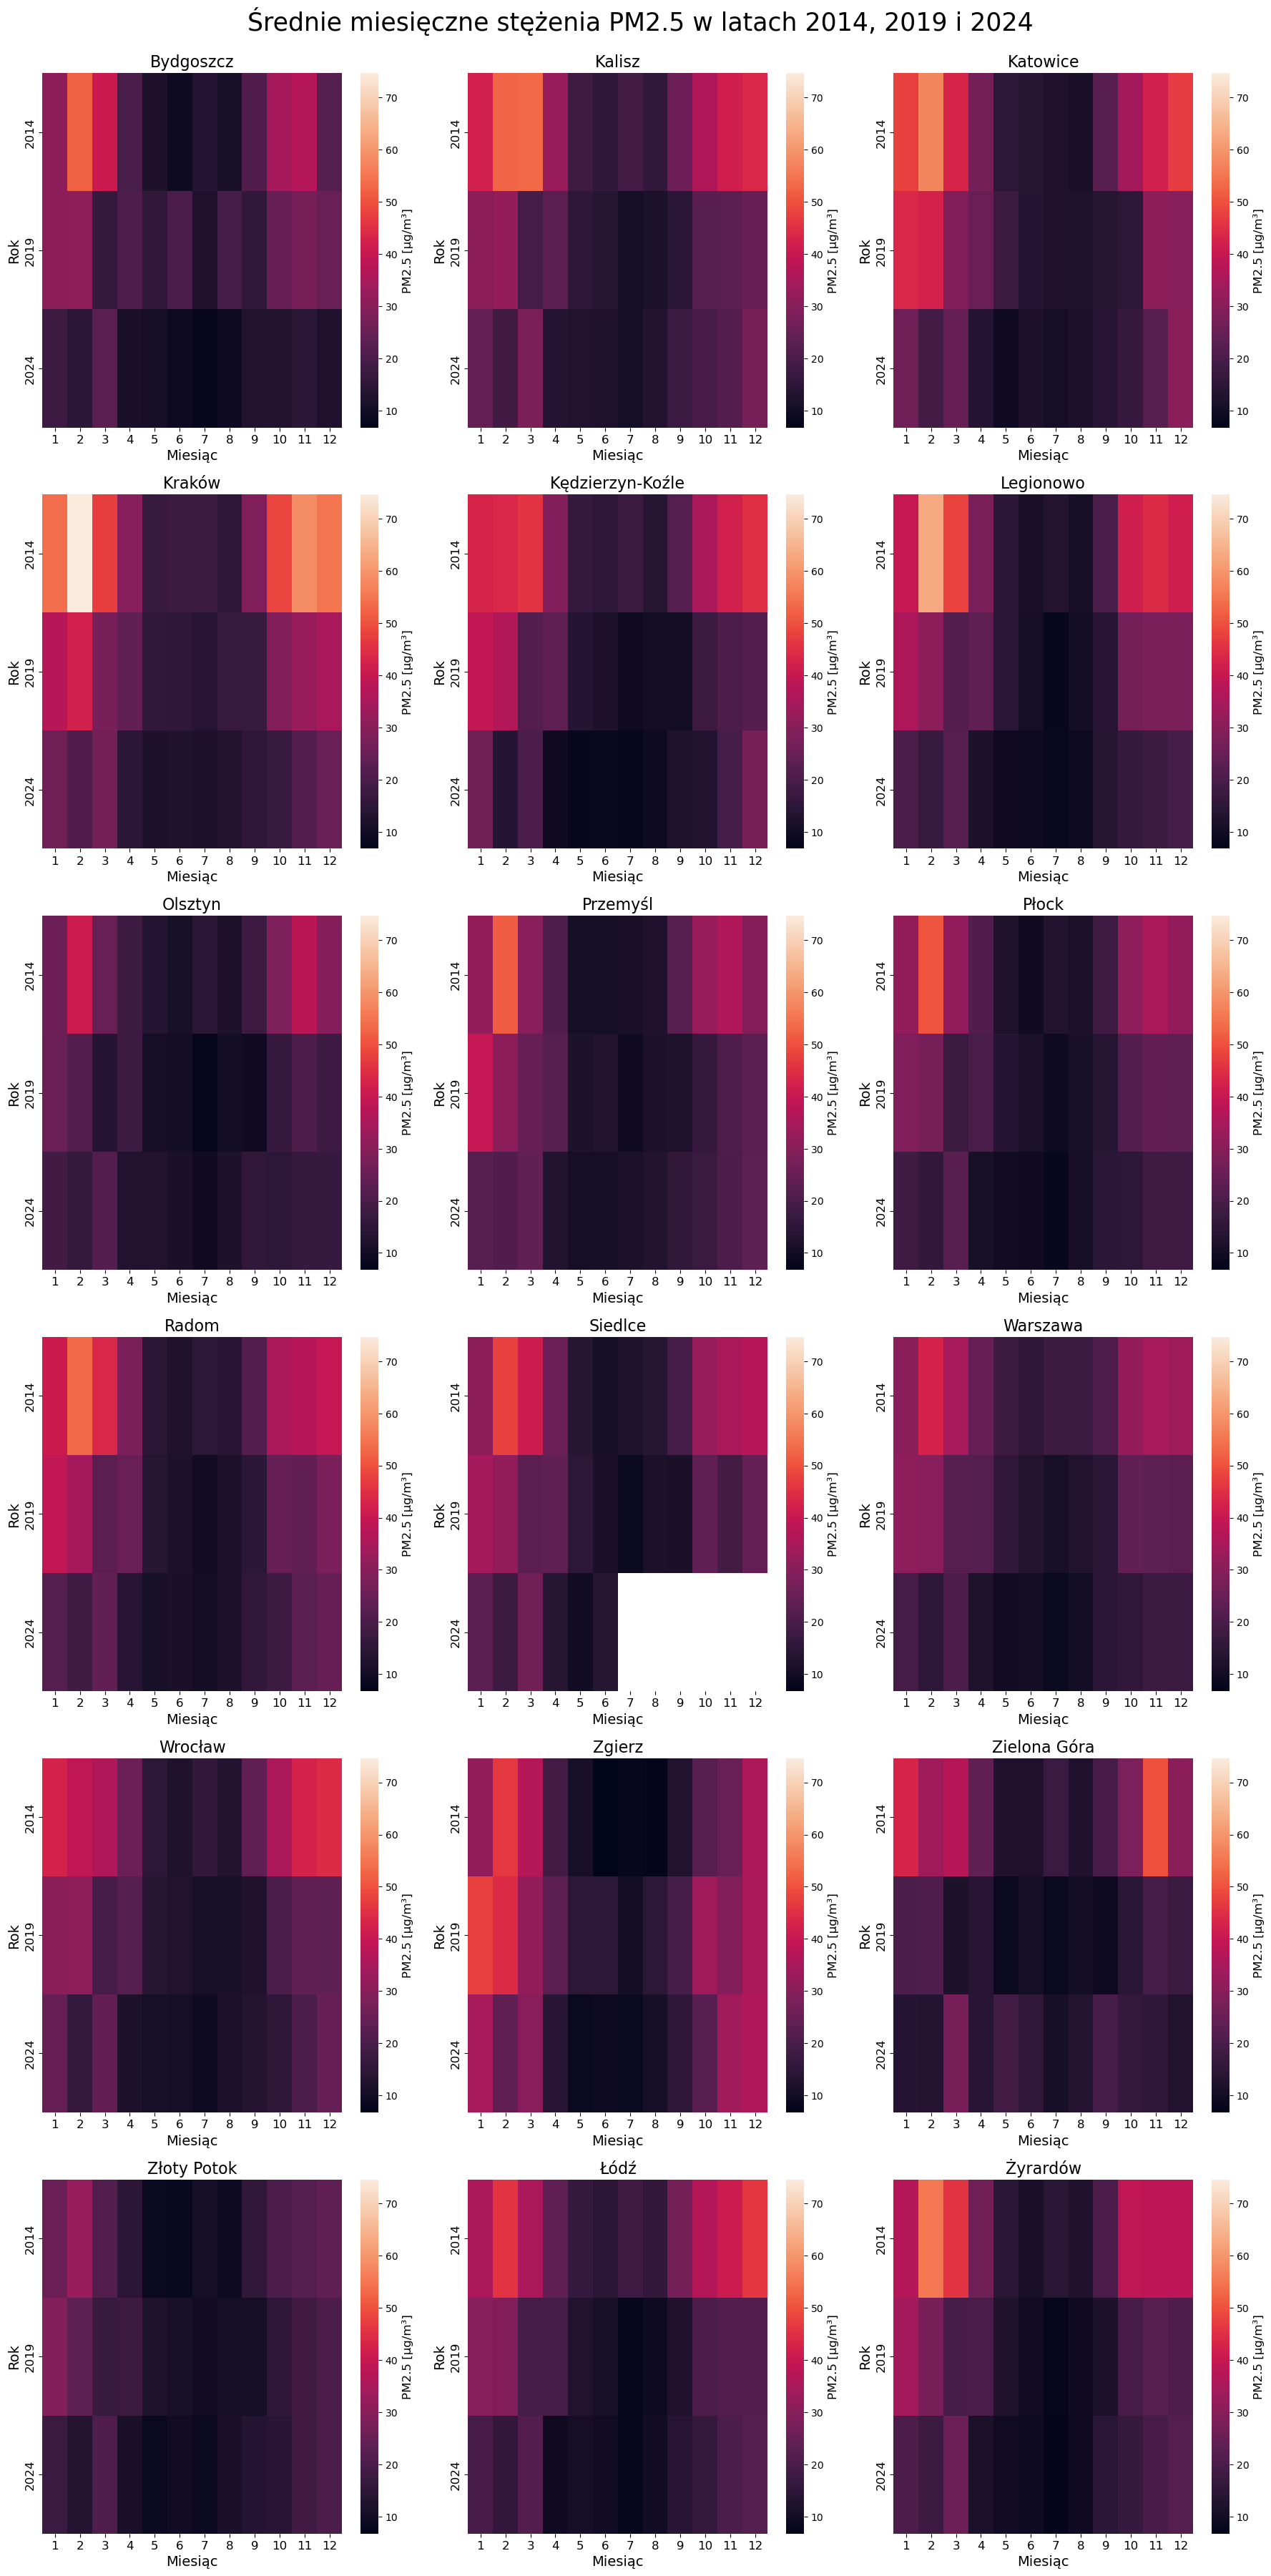

In [ ]:
def heatmaps_city_means(monthly_means):

    # Zagwarantowanie odpowiedniego typu średnim miesięcznym danym PM25
    monthly_means["Mean PM25"] = pd.to_numeric(monthly_means["Mean PM25"])

    # Wyznaczenie średnich miesięcznych wartości dla każdej miejscowości
    city_monthly = (
        monthly_means.groupby(["Rok", "Miesiąc", "Miejscowość"])["Mean PM25"]
        .mean()
        .reset_index()
    )

    # Stworzenie listy unikalnych miejscowości
    cities = city_monthly["Miejscowość"].unique()

    # Wyznaczenie zakresów PM25, co pozwoli na uzyskanie wspólnej skali dla wszystkich heatmap
    vmin = city_monthly["Mean PM25"].min()
    vmax = city_monthly["Mean PM25"].max()

    # Utworzenie siatki wykresów (6 x 3)
    fig, axes = plt.subplots(6, 3, figsize=(18, 36))
    axes = axes.flatten()

    # Generowanie heatmap dla kolejnych miejscowości
    for ax, city in zip(axes, cities):
        data = city_monthly[city_monthly["Miejscowość"] == city]

        # Modyfikacja tabeli: wiersze - lata, kolumny - miesiące
        pivot = data.pivot(index="Rok", columns="Miesiąc", values="Mean PM25")

        hm = sns.heatmap(data=pivot, vmin=vmin, vmax=vmax, ax=ax)

        ax.set_title(city, fontsize=16)
        ax.tick_params(axis="both", labelsize=12)
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)
        cbar = hm.collections[0].colorbar
        cbar.set_label("PM2.5 [µg/m³]", fontsize=12)

        fig.suptitle(
            "Średnie miesięczne stężenia PM2.5 w latach 2014, 2019 i 2024",
            fontsize=25,
            y=0.999,
        )
    plt.tight_layout()


heatmaps_city_means(df_means)

## Analiza i interpretacja danych
Z 20 stacji występujących w oczyszczonych danych otrzymano 18 heatmap (2 miejscowości posiadały po dwie stacje) średnich miejsięcznych stężeń pyłu PM2.5 uśrednionych po stacjach w danej miejscowości.

- Niezależnie od analizowanej miejscowości najwyższe stężenia pyłu PM2.5 występują w miesiącach jesiennych i zimowych (od października do marca), co może być związane z trwającym w tym czasie sezonem grzewczym. Najniższe wartości obserwowane są natomiast w miesiącach wiosennych i letnich. Cykliczność ta pozostaje niezmienna na przestrzeni lat.

- Występują wyraźne różnice w poziomach stężeń pyłu między miejscowościami. Najwyższe wartości odnotowano w Krakowie w lutym 2014 roku.

- W analizowanych latach (2014, 2019, 2024) jakość powietrza uległa wyraźnej poprawie. Powietrze w 2014 roku było znacznie bardziej zanieczyszczone niż powietrze w 2024. Choć spadki jakości powietrza nadal pojawiają się w miesiącach zimowych, są one znacznie mniejsze niż wcześniej. Może to wynikać zarówno z rosnącej świadomości społecznej dotyczącej znaczenia czystego powietrza, jak i z realizacji programów wymiany pieców.


# Zadanie 4

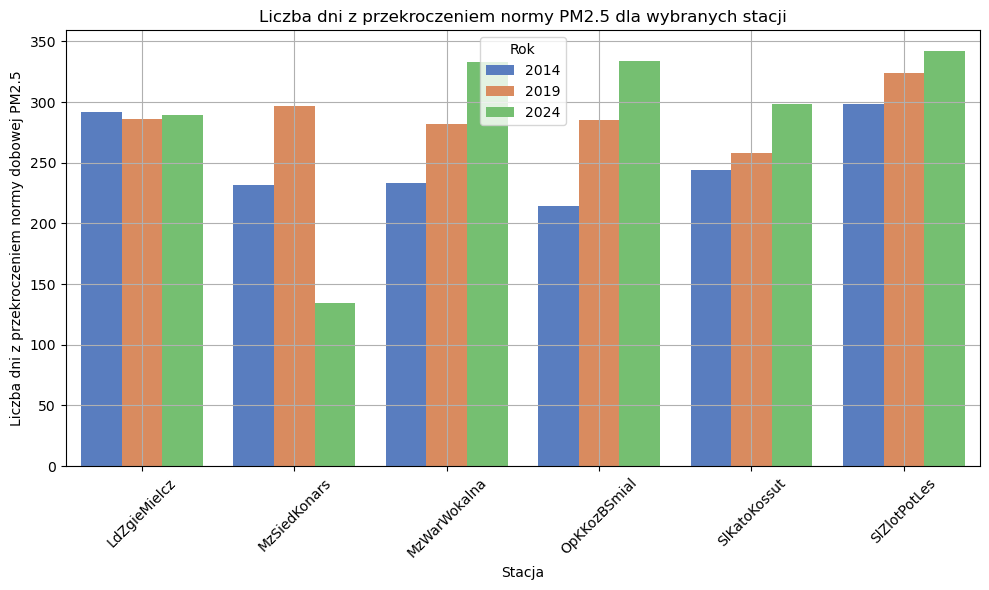

In [ ]:
import seaborn as sns


# funkcja zlicza dni dla każdej stacji, w których wartość PM2.5 była ponad normą
def count_overnorm_days(df_days):
    df = df_days.copy()
    df["Data"] = df["datetime"].dt.date
    df_pm25_over = (
        df[df["PM25"] < 15]
        .groupby(["Rok", "Kod stacji"])["Data"]
        .nunique()
        .reset_index()
        .rename(columns={"Data": "Liczba dni PM25 > 15"})
    )

    return df_pm25_over


# funkcja zwraca 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku
def get_top_bottom_stations(df_over, year):
    df = df_over.copy()
    df = df[df["Rok"] == year]
    top_3 = df.nlargest(3, "Liczba dni PM25 > 15")
    bottom_3 = df.nsmallest(3, "Liczba dni PM25 > 15")
    df_concat = pd.concat([top_3, bottom_3])

    return df_concat


# funkcja zwraca grouped barplot dla 6 stacji znalezionych w poprzedniej funkcji i grupuje je według lat
def plot_stations(df_t_b, df_over):
    df = df_t_b.copy()
    stations = df["Kod stacji"]
    df_stations = df_over[df_over["Kod stacji"].isin(stations)]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_stations,
        x="Kod stacji",
        y="Liczba dni PM25 > 15",
        hue="Rok",
        palette="muted",
    )

    plt.title("Liczba dni z przekroczeniem normy PM2.5 dla wybranych stacji")
    plt.xlabel("Stacja")
    plt.ylabel("Liczba dni z przekroczeniem normy dobowej PM2.5")
    plt.xticks(rotation=45)
    plt.legend(title="Rok")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


df_overnorm = count_overnorm_days(df_pm25_formated)
df_top_bottom = get_top_bottom_stations(df_over=df_overnorm, year=2024)
plot_stations(df_t_b=df_top_bottom, df_over=df_overnorm)

## Interpretacja wykresu
- W 4/6 stacji widać, że w 2014 roku było najmniej dni z przekroczeniem normy dobowej wartości PM2.5, natomiast wraz z upływem lat - liczba dni rosła. 
- Z kolei na stacji LdZgieMielcz liczba dni, w których zarejestrowano przekroczenie normy tego parametru jest praktycznie stała w latach 2014, 2019, 2024. 
- Jeśli chodzi o stację MzSiedKonars - najwięcej dni z przekroczeniem normy PM2.5 zarejestrowano w roku 2019, natomiast o połowę mniej w 2024. Jest to tym samym stacja o najmniejszej sumarycznej liczbie dni, w których zarejestrowano przekroczenie dobowej normy PM2.5.